## CIFAR-10


### Get started
Assuming you have Keras > 2.2 and Tensorflow > 1.10, you will need the following libraries for comparison
- Install **DeepExplain**
https://github.com/marcoancona/DeepExplain
- Install **DeepLIFT**
https://github.com/kundajelab/deeplift
- Install **SHAP**
https://github.com/slundberg/shap

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os, pickle
sys.path.insert(0, os.path.abspath('../..'))
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D
from keras import regularizers
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy
print ("Using TF:", tf.__version__)
print ("Using Keras:", keras.__version__)

# Import DASP
from dasp import DASP, ImagePlayerIterator

#Import DeepLift
# Installation instructions: https://github.com/kundajelab/deeplift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

# Import Deep Explain (for Grad * Input, Integrated Gradients and Occlusion implementations)
# Installation instructions: https://github.com/marcoancona/DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


Using TF: 1.12.0
Using Keras: 2.2.4


In [2]:
SKIP_TRAIN = True
saved_model_file = '.model.h5'
saved_model_weights_file = '.model_weights.h5'

batch_size = 64
num_classes = 10
epochs = 15

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:], name='conv1'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', name='conv3'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), name='conv4'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, name='dense2'))
model.add(Activation('softmax'))



# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
    # Save model and weights
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
10000/10000 [==============================] - 1s 135us/step
Test loss: 0.8642687040328979
Test accuracy: 0.6942


### Define a subset of the test set to generate explanations for

In [3]:
xs = x_test[0:20]
ys = y_test[0:20]
result_shape = xs.shape[:-1] + (1,)
a_intgrad = np.zeros(result_shape)
a_res =np.zeros(result_shape)
a_rc = np.zeros(result_shape)
a_occlusion = np.zeros(result_shape)
a_dasp = np.zeros(result_shape)
a_sampling = np.zeros(result_shape)

### Use Deep Shapley propagation to compute approximate Shapley Values.
Notice that this requires to convert our original model into a propababilistic one. We provide probabilistic layers for this.
Also, this will require O(c*n) evaluations of the probabilistic network, where n is the number of input features and c is the number of coalition sizes to be tested (ideally c = n)

In [4]:
# Init DASP from a clone of the original model, without softmax activation
# Notice that we use ImagePlayerIterator which allows to compute Shapley values 
# per each pixel (using window_shape=(1,1,3)) instead of per each pixel/channel pair.
# ie. input shape: (32, 32, 3) -- attribution shape (32, 32, 1)
dasp = DASP(
    Model(model.inputs, model.layers[-2].output),
    player_generator=ImagePlayerIterator(xs, window_shape=(1,1,3))
)

nplayers 1024


In [5]:
# We want to reproduce the convergence result so we run DASP multiple times using a different number of 
# coalitions sizes (up to 32).

dasps = []
kns = [1, 2, 4, 8, 16, 32]
for xn in kns:
    print ("Evaluating with %d coalition sizes" % xn)
    s = dasp.run(xs, xn)
    # Pick only the explanation referring to the output unit corresponding to the correct class
    s = np.array([s[i, c, :] for i, c in enumerate(np.argmax(ys, 1))])
    dasps.append((xn, s))
    
a_dasp = dasps[-1][1][:, :, :]

Evaluating with 1 coalition sizes
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]
[1, 1, 1, 1]
[20, 1, 1, 1]
[(20, 32, 32, 3), (20, 32, 32, 3), (20,)]


### Use DeepExplain framework to compute attributions using Integrated Gradients and Occlusion
Occlusion is performed by replacing one pixel at the time with a zero value and measuring the difference in the target output caused by such occlusion.

In [6]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    a_occlusion = de.explain('occlusion', target_tensor * ys, input_tensor, xs, window_shape=(1, 1, 3))
     # Run with different number of steps to reproduce convergence result
    intgrads = [(k, de.explain('intgrad', target_tensor * ys, input_tensor, xs, steps=k).sum(-1)) for k in [1, 2, 4, 8, 16, 32, 64, 128]]

# Notice that Integrated Gradients produce an attribution value for each pixel/channel pair.
# We sum along the channel dimension to get an attribution value for each pixel.
a_intgrad = np.sum(a_intgrad, -1)
a_occlusion = np.sum(a_occlusion, -1)
print ("Done")

DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "occlusion" explanation method (6)
Model with multiple inputs:  False
Input shape: (32, 32, 3); window_shape (1, 1, 3); step 1
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
Done
CPU times: user 5.35 s, sys: 260 ms, total: 5.

### Use DeepLIFT framework to compute attributions according to both Rescale and RevealCancel methods

In [7]:
%%time
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

    
    
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

# Notice that DeepLIFT produce an attribution value for each pixel/channel pair.
# We sum along the channel dimension to get an attribution value for each pixel.
a_rc = a_rc[:, 0, ...].sum(-1)
a_res = a_res[:, 0, ...].sum(-1)

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
CPU times: user 49.1 s, sys: 8 ms, total: 49.2 s
Wall time: 50.3 s


### Use Shapley sampling to approximate the Ground Truth
Notice that this will take a long time (2-6 hours). You can reduce the number of evaluations per feature (now 10^13).
Sampling method as described in https://www.sciencedirect.com/science/article/pii/S0305054808000804

In [8]:
%%time
np.random.seed(14123)
from utils.shapley_sampling import run_shapley_sampling
samplings = []
def callback(snapshot):
    print ("Current %d" % snapshot[0])
    samplings.append((snapshot[0], snapshot[1]))

def run_sampling(runs):
    return run_shapley_sampling(fModel, xs, ys, runs=runs, feat_dims=[1,2], callback=callback)
a_sampling = run_sampling(2**11)

Data shape:  [20, 32, 32, 3]
Runs 2048
Shape to mask features:  [20, -1, 3]
Current 1
Current 2
Current 4
Current 8
Current 16
Current 32
Current 64
Current 128
Current 256
Current 512
Current 1024
Current 2048
CPU times: user 47min 50s, sys: 3min 39s, total: 51min 30s
Wall time: 1h 4min 30s


## Plot attribution maps for qualitative comparison

In [10]:
attributions = [
    ('IntegratedGrad',      a_intgrad), 
    ('DL\n(Rescale)',       a_res), 
    ('DL\n(RevCancel)',     a_rc), 
    ('Occlusion',           a_occlusion), 
    ('DASP',                a_dasp), 
    ('Sampling (~GT)',      a_sampling)
]

Save
(20, 32, 32, 3)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


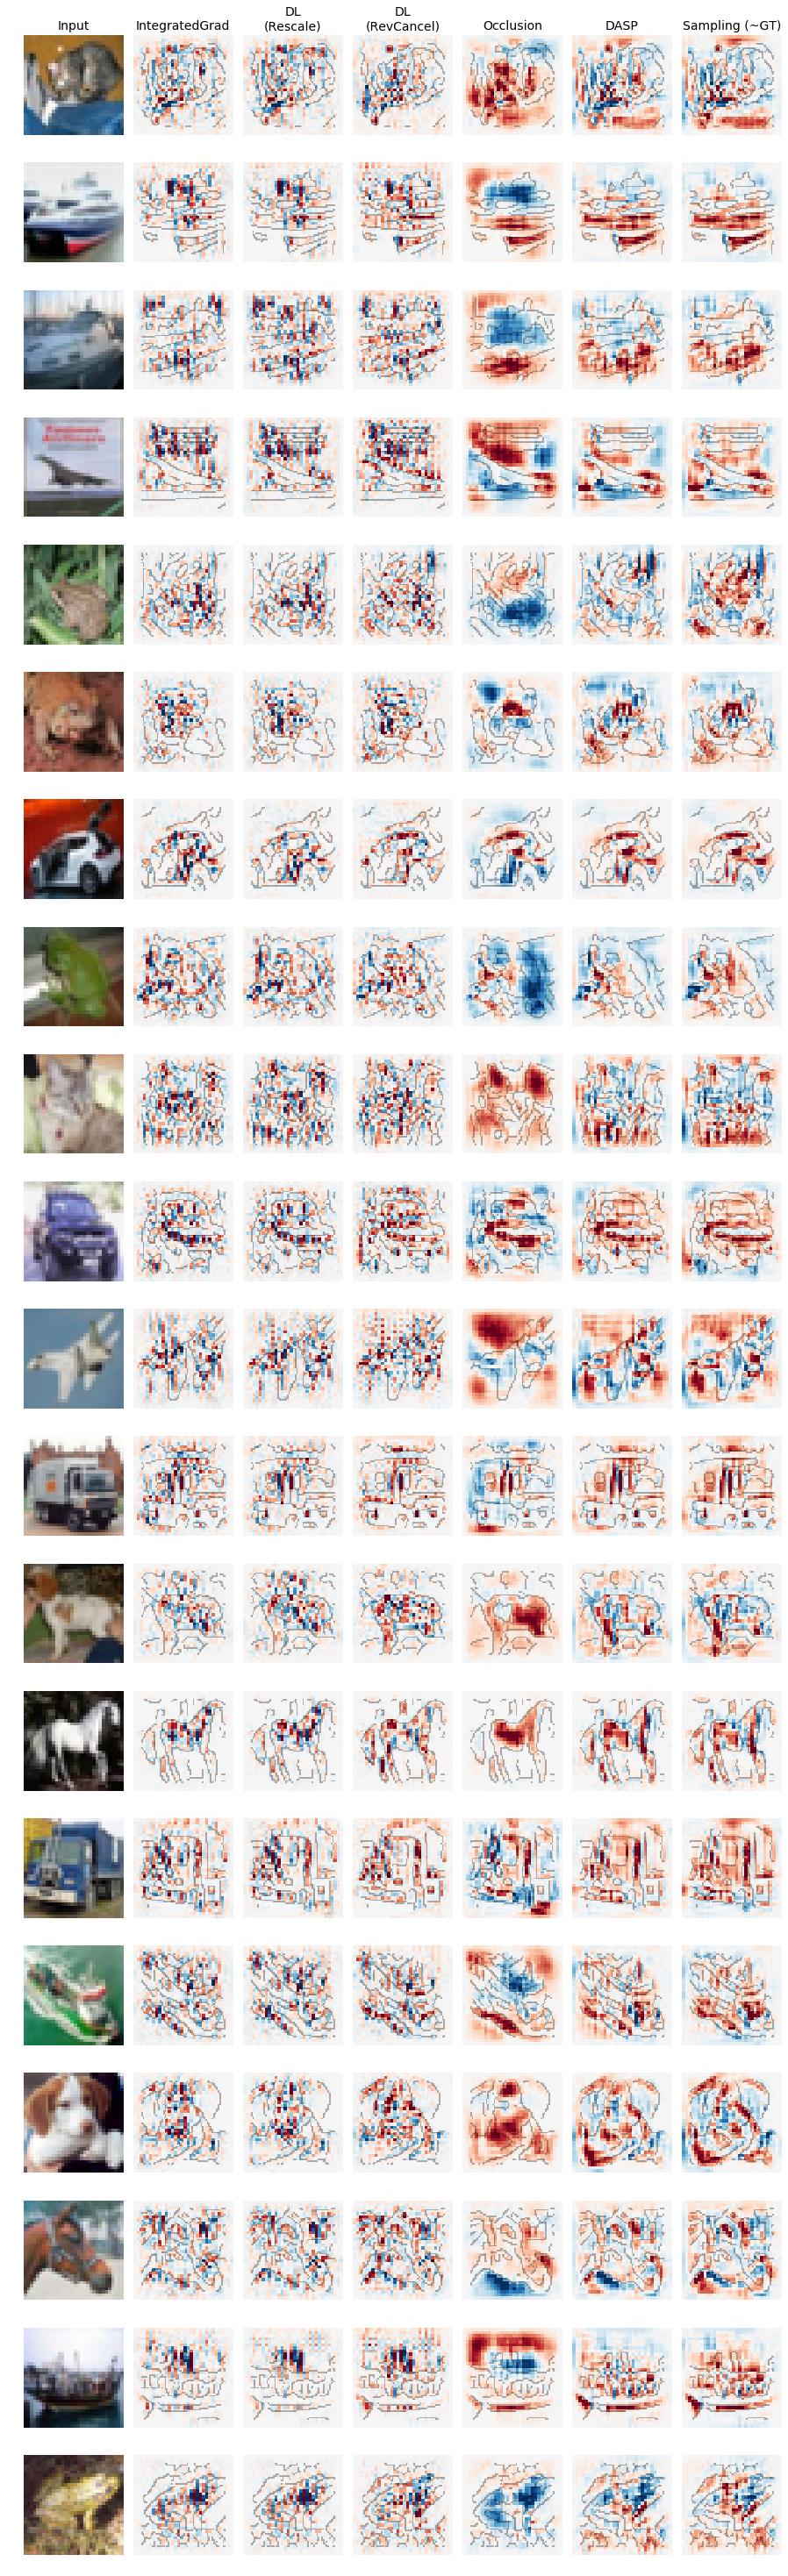

In [12]:
# Plot attributions
%matplotlib inline
from utils.utils import plot_attribution_maps

# Plot all
plot_attribution_maps("cifar10", 
                      xs, 
                      [x[1][:20] for x in attributions],
                      [x[0][:20] for x in attributions],
                      percentile=99,
                      show_original=True,
                      dilation=2,
                      alpha=0.3,
                      save_separate=True
                      )

## Quantitative comparison (MSE and Spearman rank correlation)

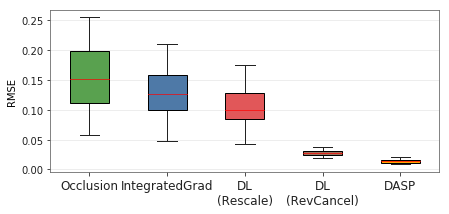

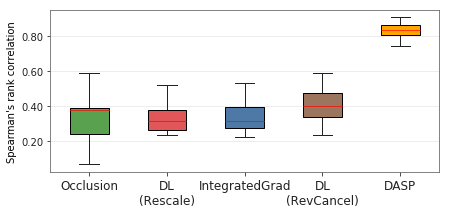

In [13]:
from utils.utils import plot_mse_comparison, plot_correlation_comparison


plot_mse_comparison('cifar10',
                    [x[1][:20] for x in attributions],
                    [x[0] for x in attributions],
                    gt_idx=-1)
plot_correlation_comparison('cifar10',
                        [x[1][:20] for x in attributions],
                        [x[0] for x in attributions],
                        gt_idx=-1)

### Run Deep Shapley with different values of kn and measure how fast it converges

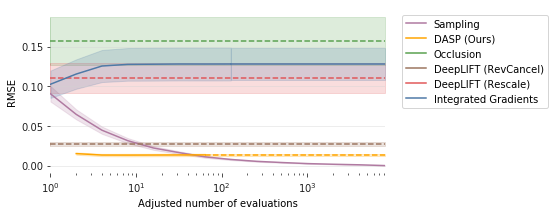

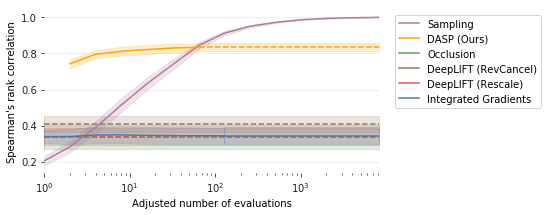

In [40]:
from utils.convergence_plot import convergence_comparison_rmse, convergence_comparison_corr
_samplings_y = [x[1] for x in samplings]
_samplings_x = [x[0] for x in samplings]
_dasps_y = [x[1] for x in dasps]
_dasps_x = [x[0] for x in dasps]
_intgrad_y = [x[1] for x in intgrads]
_intgrad_x = [x[0] for x in intgrads]
ticks = [_samplings_x, [2*x for x in _dasps_x], [1], [1], [1], _intgrad_x]
names = ['Sampling', 'DASP (Ours)', 'Occlusion', 'DeepLIFT (RevCancel)', 'DeepLIFT (Rescale)', 'Integrated Gradients']
data = [_samplings_y, _dasps_y, [a_occlusion], [a_rc], [a_res], _intgrad_y]

convergence_comparison_rmse('cifar10', data, names, ticks, a_sampling)
convergence_comparison_corr('cifar10', data, names, ticks, a_sampling)